##### Notes

# Data Exploration

### Libraries

In [14]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from PIL import Image
import clip
import torch
import skimage as sk #image processing library
import matplotlib.pyplot as plt
from PIL import Image #image processing library
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
# splitting the dataset into training and testing 80:20
from sklearn.model_selection import train_test_split

### Read & Split the Dataset

In [15]:
df = pd.read_csv("Cats&Dogs_Dataset.csv")

# only rows in image column that contain string with cat
df_cat = df[df["image"].str.contains("cat")]
# only rows in image column that contain string with dog
df_dog = df[df["image"].str.contains("dog")]

# train test split
train_cat, test_cat = train_test_split(df_cat, test_size=0.2, random_state=1)
train_dog, test_dog = train_test_split(df_dog, test_size=0.2, random_state=1)

#take only 10 rows from each dataset to train the model
train_cat = train_cat.head(20)
train_dog = train_dog.head(20)

test_cat = test_cat.head(20)
test_dog = test_dog.head(20)

### Load Clip 

In [16]:
clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [17]:
# Load model once at the beginning
# model, preprocess = clip.load("ViT-B/32", device="cpu") 
# model.eval() # move model to GPU and set it to evaluation mode

In [18]:
model , preprocess = clip.load("ViT-B/32", device="cpu")

## Setting up input images

In [19]:
# images destination
descriptions = {
"C",
"D",
} 

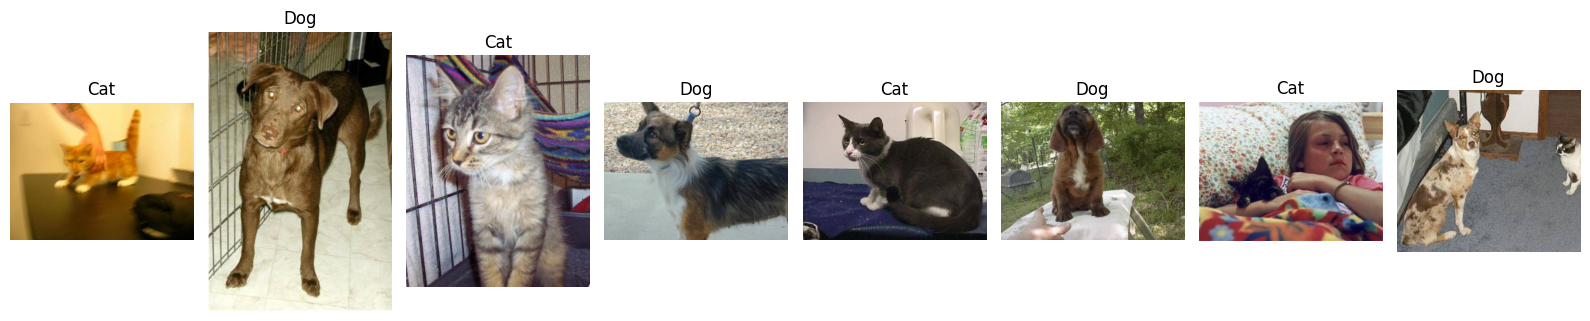

In [20]:
original_images = []
processed_images = []
descriptions = ["Cat", "Dog"]# Change set to list
plt.figure(figsize=(16, 16))

# preprocess the images
for i in range(0, 8):
    var = ''
    if i % 2 == 0: 
        var = 'cat.' + str(i) 
    else:
        var = 'dog.' + str(i)
    # original image
    original_image = Image.open('./Cats&Dogs_Pics/' + var + '.jpg')
    original_images.append(original_image)
    # processed image
    processed_image = preprocess(original_image)
    processed_images.append(processed_image)
    # description
    plt.subplot(1, 8, i + 1)
    plt.imshow(original_image)
    if i % 2 == 0:
        plt.title(descriptions[0])
    else:
        plt.title(descriptions[1])
    plt.axis("off")

plt.tight_layout()
plt.show()

In [21]:
# Building Features(preprocess the images and stack them into a tensor)
image_input_train_cat = torch.stack([preprocess(Image.open('./Cats&Dogs_Pics/' + img_path)) for img_path in train_cat['image']])
image_input_train_dog = torch.stack([preprocess(Image.open('./Cats&Dogs_Pics/' + img_path)) for img_path in train_dog['image']])

# repeat the description for each image
text_tokens_train_cat = clip.tokenize(descriptions[0] * len(train_cat)) 
text_tokens_train_dog = clip.tokenize(descriptions[1] * len(train_dog))

#encode the text and convert to float
text_features_train_cat = model.encode_text(text_tokens_train_cat).float() 
text_features_train_dog = model.encode_text(text_tokens_train_dog).float()

# Combine image and text features
with torch.no_grad(): #disable gradient calculation to speed up computation and reduce memory consumption
    image_features_train_cat = model.encode_image(image_input_train_cat).float()
    image_features_train_dog = model.encode_image(image_input_train_dog).float()

In [22]:
#preprocess the images and stack them into a tensor
image_input_test_cat = torch.stack([preprocess(Image.open('./Cats&Dogs_Pics/' + img_path)) for img_path in test_cat['image']]) 
image_input_test_dog = torch.stack([preprocess(Image.open('./Cats&Dogs_Pics/' + img_path)) for img_path in test_dog['image']]) 

#tokenize the text and stack them into a tensor
text_tokens_test_cat = clip.tokenize(descriptions[0] * len(test_cat)) 
text_tokens_test_dog = clip.tokenize(descriptions[1] * len(test_dog))

#encode the text and convert to float
text_features_test_cat = model.encode_text(text_tokens_test_cat).float()
text_features_test_dog = model.encode_text(text_tokens_test_dog).float()

# Combine image and text features
with torch.no_grad(): #disable gradient calculation to speed up computation and reduce memory consumption
    image_features_test_cat = model.encode_image(image_input_test_cat).float()
    image_features_test_dog = model.encode_image(image_input_test_dog).float()

text_features_test_cat.type()

'torch.FloatTensor'

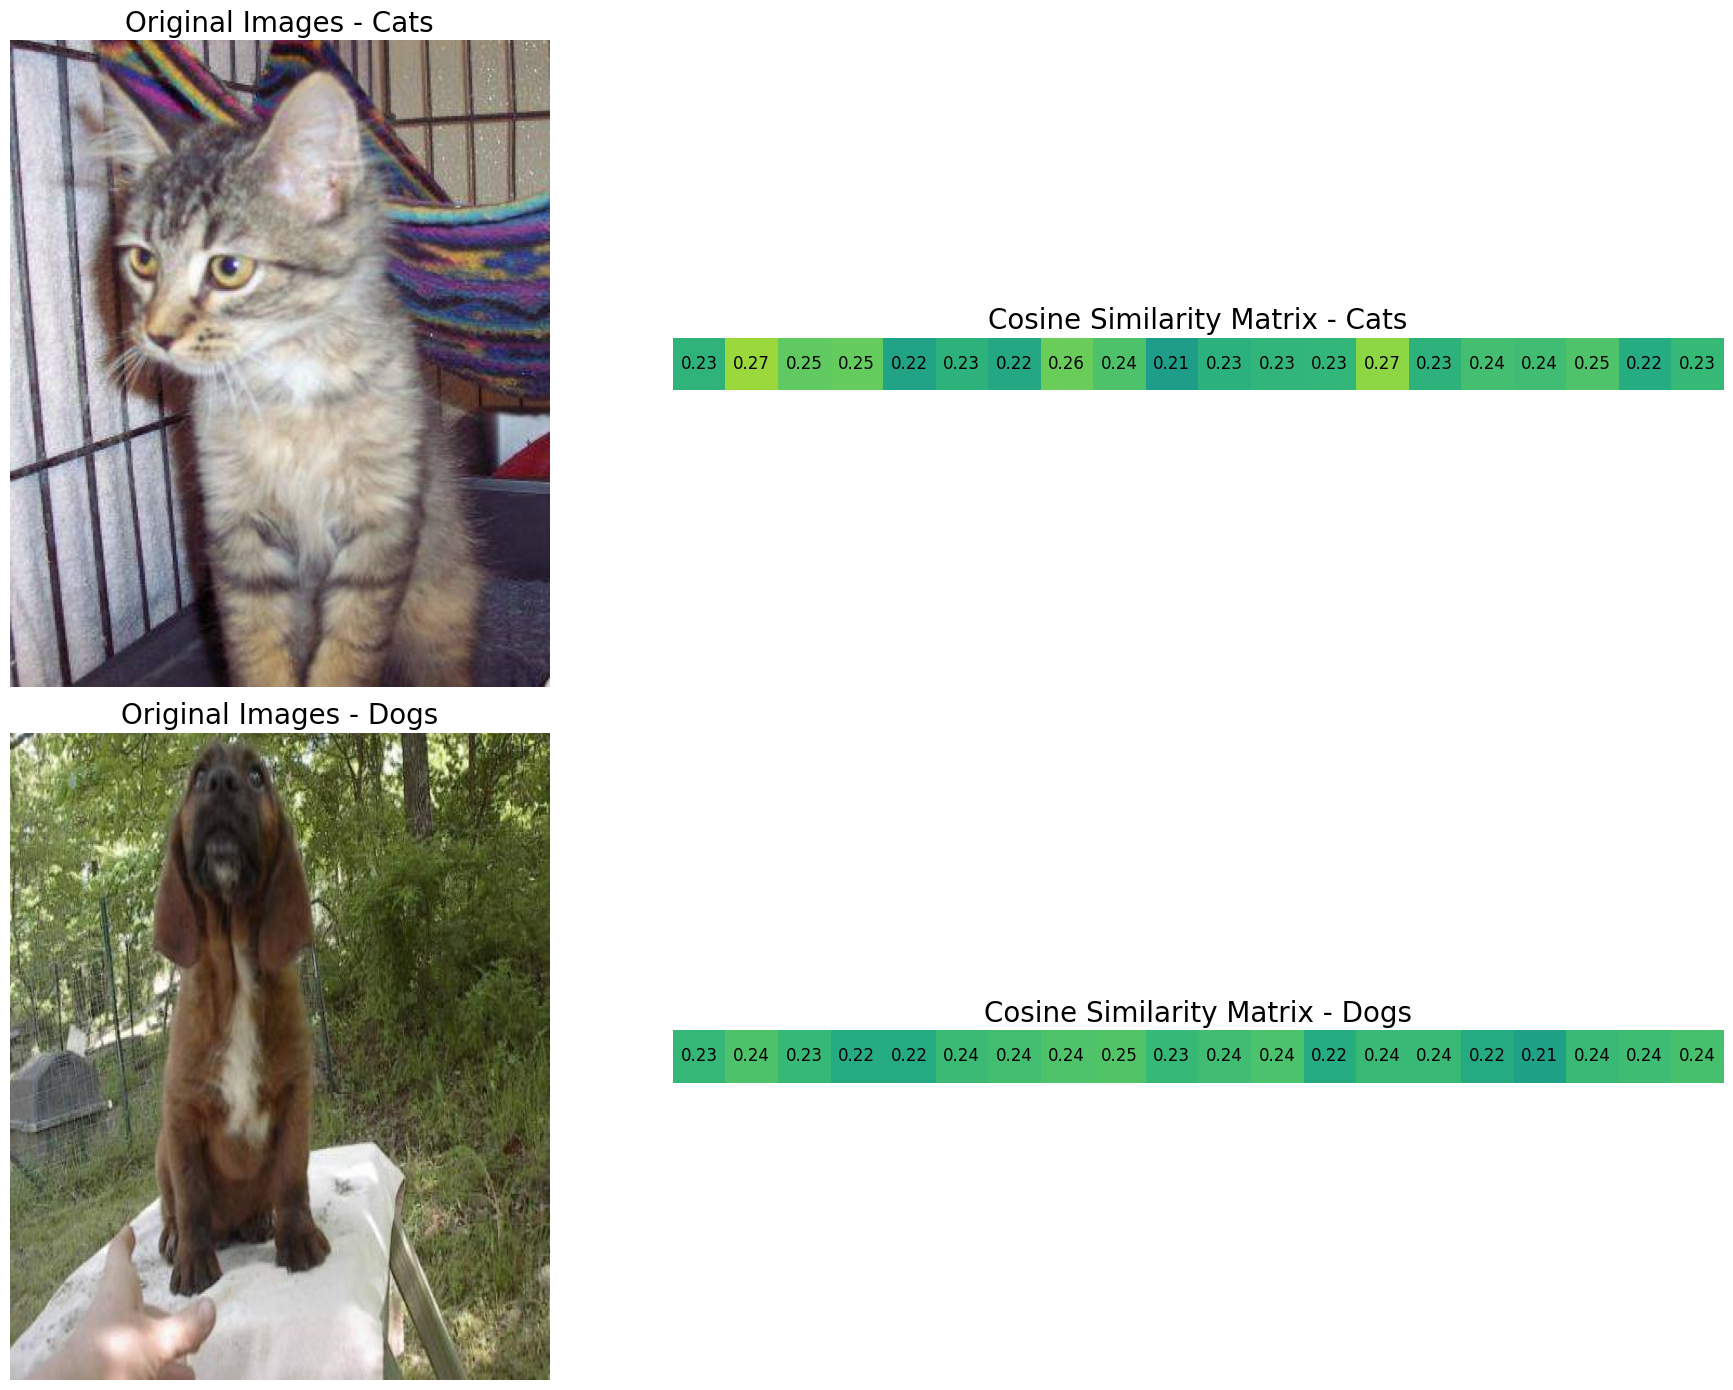

In [23]:
def calculate_and_visualize_combined_cosine_similarity(image_features_cat, text_features_cat, image_features_dog, text_features_dog, descriptions, original_images):
    # Normalize the features
    image_features_cat /= image_features_cat.norm(dim=-1, keepdim=True)
    text_features_cat /= text_features_cat.norm(dim=-1, keepdim=True)
    image_features_dog /= image_features_dog.norm(dim=-1, keepdim=True)
    text_features_dog /= text_features_dog.norm(dim=-1, keepdim=True)

    # Calculate cosine similarity for both cats and dogs
    similarity_matrix_cat = text_features_cat.detach().numpy() @ image_features_cat.detach().numpy().T
    similarity_matrix_dog = text_features_dog.detach().numpy() @ image_features_dog.detach().numpy().T

    # Create a combined visualization
    count_cat = len(descriptions[0])
    count_dog = len(descriptions[1])

    plt.figure(figsize=(20, 14))

    # Plot Cat Images
    plt.subplot(2, 2, 1)
    for i, image in enumerate(original_images[:count_cat]):
        plt.imshow(image, extent=(i - 0.5, i + 0.5, -0.6, 0.6), origin="upper")  # Adjust extent and origin
    plt.yticks([])
    plt.xticks([])
    plt.title("Original Images - Cats", size=20)

    for side in ["left", "top", "right", "bottom"]:
        plt.gca().spines[side].set_visible(False)

    # Plot Cosine Similarity Matrix for Cats
    plt.subplot(2, 2, 2)
    plt.imshow(similarity_matrix_cat, vmin=0.1, vmax=0.3, cmap='viridis', origin="upper")  # Adjust origin
    plt.yticks([])
    plt.xticks([])
    plt.title("Cosine Similarity Matrix - Cats", size=20)

    for x in range(similarity_matrix_cat.shape[1]):
        for y in range(similarity_matrix_cat.shape[0]):
            plt.text(x, y, f"{similarity_matrix_cat[y, x]:.2f}", ha="center", va="center", size=12)

    for side in ["left", "top", "right", "bottom"]:
        plt.gca().spines[side].set_visible(False)

    # Plot Dog Images
    plt.subplot(2, 2, 3)
    for i, image in enumerate(original_images[count_cat:count_cat + count_dog]):
        plt.imshow(image, extent=(i - 0.5, i + 0.5, -0.6, 0.6), origin="upper")  # Adjust extent and origin
    plt.yticks([])
    plt.xticks([])
    plt.title("Original Images - Dogs", size=20)

    for side in ["left", "top", "right", "bottom"]:
        plt.gca().spines[side].set_visible(False)

    # Plot Cosine Similarity Matrix for Dogs
    plt.subplot(2, 2, 4)
    plt.imshow(similarity_matrix_dog, vmin=0.1, vmax=0.3, cmap='viridis', origin="upper")  # Adjust origin
    plt.yticks([])
    plt.xticks([])
    plt.title("Cosine Similarity Matrix - Dogs", size=20)

    for x in range(similarity_matrix_dog.shape[1]):
        for y in range(similarity_matrix_dog.shape[0]):
            plt.text(x, y, f"{similarity_matrix_dog[y, x]:.2f}", ha="center", va="center", size=12)

    for side in ["left", "top", "right", "bottom"]:
        plt.gca().spines[side].set_visible(False)

    plt.tight_layout()
    plt.show()

# Visualize Combined Cosine Similarity Matrix for Cats and Dogs
calculate_and_visualize_combined_cosine_similarity(image_features_train_cat, text_features_train_cat, image_features_train_dog, text_features_train_dog, descriptions, original_images)


# Fisher's Algorithm


In [24]:
mean_cat = torch.mean(image_features_train_cat, dim=0)  # Calculate mean for cat features
mean_dog = torch.mean(image_features_train_dog, dim=0)  # Calculate mean for dog features

# scatter matrices for cats and dogs
scatter_cat = torch.matmul((image_features_train_cat - mean_cat).T, (image_features_train_cat - mean_cat))
scatter_dog = torch.matmul((image_features_train_dog - mean_dog).T, (image_features_train_dog - mean_dog))

# The whole baa class scatter matrix (Sw)
Sw = scatter_cat + scatter_dog

C_values = [0.1, 1, 10]  # Different values of C to try
best_accuracy = 0
best_C = None

for C in C_values:
    sInv = torch.inverse(Sw)
    w = C * torch.matmul(sInv, (mean_dog - mean_cat))
    
    # Combining test& train features and labels
    test_features = torch.cat((image_features_test_cat, image_features_test_dog), dim=0)
    test_labels = torch.cat((torch.zeros(len(test_cat)), torch.ones(len(test_dog))), dim=0)  # 0 for cats, 1 for dogs
    train_features = torch.cat((image_features_train_cat, image_features_train_dog), dim=0)
    train_labels = torch.cat((torch.zeros(len(train_cat)), torch.ones(len(train_dog))), dim=0)  # 0 for cats, 1 for dogs

    # Perform hyperparameter tuning
    param_grid = {
        'n_estimators': [100, 200, 300], #number of trees in the forest
        'max_depth': [None, 10, 20], #maximum depth of the tree
    }

    grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5) #GridSearchCV performs hyperparameter tuning
    grid_search.fit(train_features, train_labels) #fit the model

    best_params = grid_search.best_params_ 
    
    # Re-train your model using the best parameters
    best_model = RandomForestClassifier(n_estimators=best_params['n_estimators'], max_depth=best_params['max_depth'])
    best_model.fit(train_features, train_labels)

    # Make predictions
    threshold = 0.6  
    predicted_probability = best_model.predict_proba(test_features)
    predicted = (predicted_probability[:, 1] >= threshold).astype(int)

    # Calculate accuracy
    accuracy = accuracy_score(test_labels, predicted)

    # Check if this value of C gives a higher accuracy
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_C = C

print(f"Best C value: {best_C} with Accuracy: {best_accuracy}")


# Evaluation

In [ ]:
# Evaluation metrics
conf_matrix = confusion_matrix(test_labels, predicted)
accuracy = accuracy_score(test_labels, predicted)
precision = precision_score(test_labels, predicted)
recall = recall_score(test_labels, predicted)
f1 = f1_score(test_labels, predicted)

print(f"Accuracy: {best_accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.98
Precision: 1.0
Recall: 0.94
F1 Score: 0.9690721649484536


# Visualization

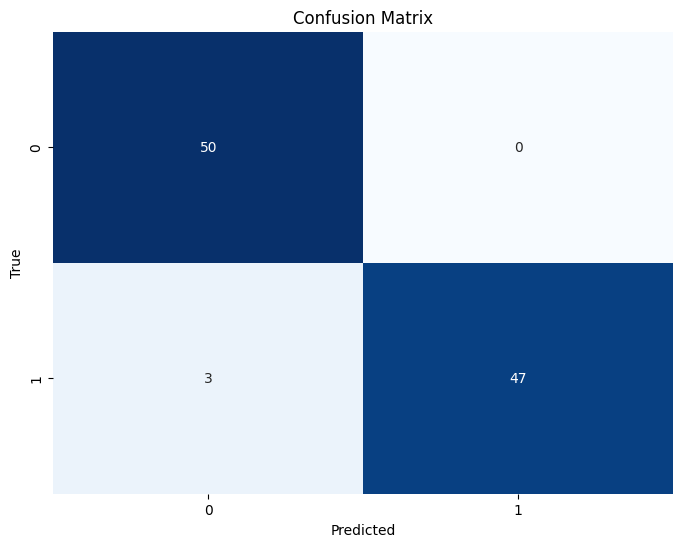

In [ ]:
# Visualizing the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()